# Getting Started

It is relatively easy to get going with a quick simulation in OpenPNM.
In fact the following code block produces a mercury intrusion simulation in
just a few lines.

## Creating a Cubic Network

In [13]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt
op.visualization.set_mpl_style()

Nx, Ny, Nz = 10, 10, 10
Lc = 1e-4
pn = op.network.Cubic([Nx, Ny, Nz], spacing=Lc)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x7fafd7ccd270>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                   1000 / 1000
  3  throat.conns                                                  2700 / 2700
  4  pore.coordination_number                                      1000 / 1000
  5  pore.max_size                                                 1000 / 1000
  6  throat.spacing                                                2700 / 2700
  7  pore.seed                                                     1000 / 1000
  8  pore.diameter                                                 1000 / 1000
  9  throat.max_size                                               2700 / 2700
 10

## Defining a Phase

In [14]:
hg = op.phase.Mercury(network=pn)
hg.add_model(propname='throat.entry_pressure',
             model=op.models.physics.capillary_pressure.washburn)
hg.regenerate_models()
print(hg)


══════════════════════════════════════════════════════════════════════════════
phase_01 : <openpnm.phase.Mercury at 0x7fafd81efae0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.temperature                                              1000 / 1000
  3  pore.pressure                                                 1000 / 1000
  4  throat.contact_angle                                          2700 / 2700
  5  pore.thermal_conductivity                                     1000 / 1000
  6  pore.surface_tension                                          1000 / 1000
  7  pore.viscosity                                                1000 / 1000
  8  pore.density                                                  1000 / 1000
  9  pore.molar_density                                            1000 / 100

## Performing a Drainage Simulation

In [15]:
mip = op.algorithms.Drainage(network=pn, phase=hg)
mip.set_inlet_BC(pores=pn.pores(['left', 'right']))
mip.run(pressures=np.logspace(4, 6))

Performing drainage simulation:   0%|          | 0/50 [00:00<?, ?it/s]

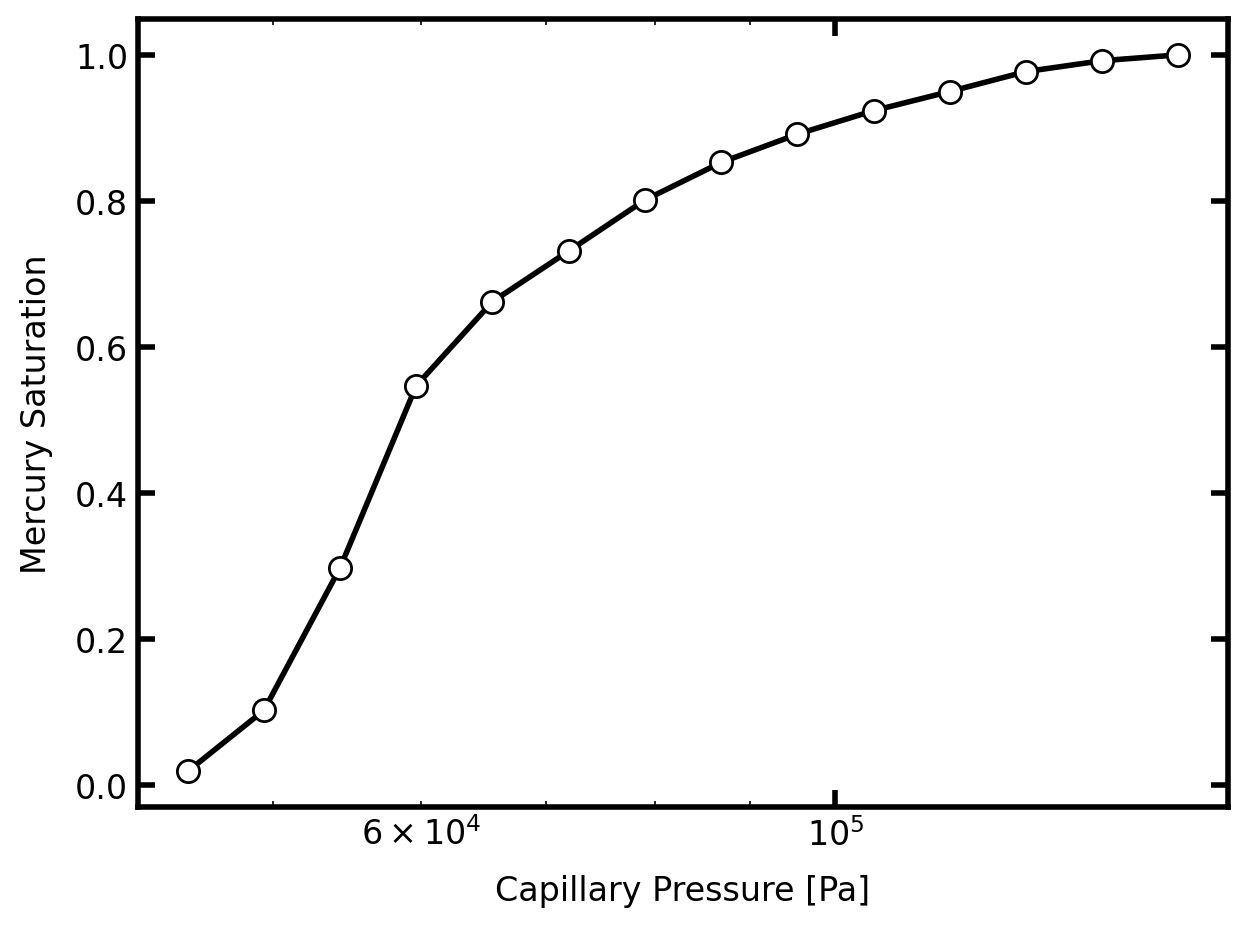

In [16]:
data = mip.pc_curve()
fig, ax = plt.subplots()
ax.semilogx(data.pc, data.snwp, 'k-o')
ax.set_xlabel('Capillary Pressure [Pa]')
ax.set_ylabel('Mercury Saturation');

## Calculating Permeability Coefficient

As another example, the permeability coefficient can be found as follows:

In [17]:
# Generate phase and physics
water = op.phase.Water(network=pn)
water.add_model(propname='throat.hydraulic_conductance',
                model=op.models.physics.hydraulic_conductance.generic_hydraulic)

# Create algorithm, set boundary conditions and run simulation
sf = op.algorithms.StokesFlow(network=pn, phase=water)
Pin, Pout = (200_000, 101_325)
sf.set_value_BC(pores=pn.pores('left'), values=Pin)
sf.set_value_BC(pores=pn.pores('right'), values=Pout)
sf.run()

The total flow rate into the domain through the boundary pores can be found
using ``sf.rate(pores=pn.pores('xmin'))``. The permeability coefficient
can be found by inserting known values into Darcy's law as follows:

In [18]:
Q = sf.rate(pores=pn.pores('left'))
A = Ny*Nz*Lc**2
L = Nx*Lc
mu = water['pore.viscosity'].mean()
K = Q*mu*L/(A*(Pin-Pout))
print(K)

[6.43550367e-13]


## Adjusting Pore Size Distribution

It's also worth explaining how to adjust the pore size distribution of the network, so that the capillary curve and permeability coefficient can be changed to match known values. The ``geo`` object controls the geometric properties, and it possess models to calculate values on demand. Let's change the pore size distribution to a Weibull distribution, but first let's store the existing values in a dummy variable so we can compare later.

In [19]:
import openpnm.models.geometry as gmods

pn['pore.old_diameter'] = pn.pop('pore.diameter')
pn.add_model(propname='pore.diameter',
             model=gmods.pore_size.weibull,
             shape=0.5, loc=0, scale=1e-5)

Now you can use `matplotlib.` to get a quick glance at the histograms of the two distributions.

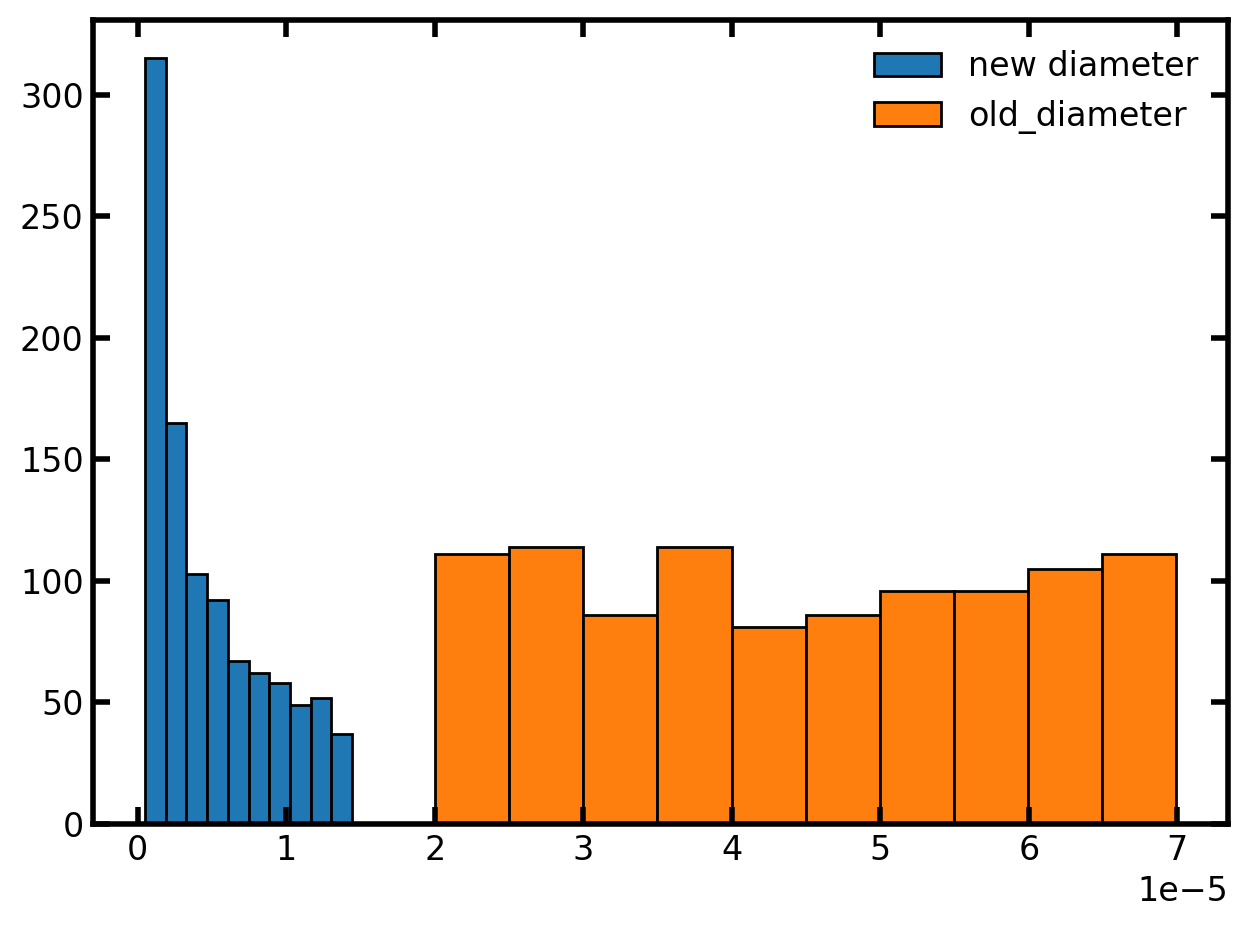

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(pn['pore.diameter'], edgecolor='k', label='new diameter')
ax.hist(pn['pore.old_diameter'], edgecolor='k', label='old_diameter')
ax.legend();

More complex tasks are explained in the [examples](../_examples/index) page.